In [33]:
#Importing the necessary libraries

import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

import statsmodels.api as sm


In [34]:
#Global Settings 
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [35]:
#Importing Configs
# Define the path where config.py is located
#Mac
os.chdir('/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling')
config_file_path = os.getcwd()
print(config_file_path)

# Add this path to the sys.path
sys.path.append(config_file_path)

import config

#Configs
finbert_models = config.finbert_models
Body = config.Body
database = config.Local_Database

/Users/kylenabors/Documents/GitHub/Finance-ML-Modeling


In [36]:
sentiment = pd.date_range(start='1/1/1990', end='1/1/2024', freq='D')
sentiment = pd.DataFrame(sentiment, columns=['date'])

state = pd.read_csv(f"{finbert_models}/{Body}/Statements/{Body}_Statements_finbert_model_short.csv")
state = state[['date','sentiment']]
state = state.rename(columns={'sentiment':'statement_sentiment'})
state['date'] = pd.to_datetime(state['date'])
sentiment = pd.merge(sentiment, state, how='left', left_on='date', right_on='date')

minutes = pd.read_csv(f"{finbert_models}/{Body}/Minutes/{Body}_Minutes_finbert_model_short.csv")
minutes = minutes[['date','sentiment']]
minutes = minutes.rename(columns={'sentiment':'minute_sentiment'})
minutes['date'] = pd.to_datetime(minutes['date'])
sentiment = pd.merge(sentiment, minutes, how='left', left_on='date', right_on='date')

fed_speech = pd.read_csv(f"{finbert_models}/{Body}/Speeches/{Body}_Speeches_finbert_model_short.csv")
fed_speech = fed_speech[['date','sentiment']]
fed_speech = fed_speech.rename(columns={'sentiment':'fed_speech_sentiment'})
fed_speech['date'] = pd.to_datetime(fed_speech['date'])
sentiment = pd.merge(sentiment, fed_speech, how='left', left_on='date', right_on='date')

Body = 'ECB'
mpd = pd.read_csv(f"{finbert_models}/{Body}/Monetary policy decisions/{Body}_Monetary policy decisions_finbert_model_short.csv")
mpd = mpd[['date','sentiment']]
mpd = mpd.rename(columns={'sentiment':'mpd_sentiment'})
mpd['date'] = pd.to_datetime(mpd['date'])
sentiment = pd.merge(sentiment, mpd, how='left', left_on='date', right_on='date')

pc = pd.read_csv(f"{finbert_models}/{Body}/Press Conferences/{Body}_Press Conferences_finbert_model_short.csv")
pc = pc[['date','sentiment']]
pc = pc.rename(columns={'sentiment':'pc_sentiment'})
pc['date'] = pd.to_datetime(pc['date'])
sentiment = pd.merge(sentiment, pc, how='left', left_on='date', right_on='date')

ecb_speech = pd.read_csv(f"{finbert_models}/{Body}/Speeches/{Body}_Speeches_finbert_model_short.csv")
ecb_speech = ecb_speech[['date','sentiment']]
ecb_speech = ecb_speech.rename(columns={'sentiment':'ecb_speech_sentiment'})
ecb_speech['date'] = pd.to_datetime(ecb_speech['date'])
sentiment = pd.merge(sentiment, ecb_speech, how='left', left_on='date', right_on='date')

In [37]:
#delete dataframes to save memory

del state, minutes, fed_speech, mpd, pc, ecb_speech


In [38]:
sentiment = sentiment.groupby('date').mean()

In [ ]:
mich = pd.read_csv(f'{database}/Market Data/Michigan/michigan_sent.csv')
#convert Month from a string to a number
mich['Month'] = mich['Month'].str.replace('January', '01')
mich['Month'] = mich['Month'].str.replace('February', '02')
mich['Month'] = mich['Month'].str.replace('March', '03')
mich['Month'] = mich['Month'].str.replace('April', '04')
mich['Month'] = mich['Month'].str.replace('May', '05')
mich['Month'] = mich['Month'].str.replace('June', '06')
mich['Month'] = mich['Month'].str.replace('July', '07')
mich['Month'] = mich['Month'].str.replace('August', '08')
mich['Month'] = mich['Month'].str.replace('September', '09')
mich['Month'] = mich['Month'].str.replace('October', '10')
mich['Month'] = mich['Month'].str.replace('November', '11')
mich['Month'] = mich['Month'].str.replace('December', '12')
    
#combine Month and YYYY columns and convert to datetime
mich['date'] = mich['Month'].astype(str) + '-' + mich['YYYY'].astype(str)
mich['date'] = pd.to_datetime(mich['date'])
mich = mich[['date', 'ICS_ALL']]
mich = mich.rename(columns={'ICS_ALL':'michigan_sentiment'})
print(mich.head())

sentiment = pd.merge(sentiment, mich, how='outer', left_on='date', right_on='date')

        date  michigan_sentiment
0 1952-11-01             86.2000
1 1953-02-01             90.7000
2 1953-08-01             80.8000
3 1953-11-01             80.7000
4 1954-02-01             82.0000


/var/folders/9h/v8gnzwrs73v52x4lyzz2z2zc0000gn/T/ipykernel_80709/2282812921.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mich['date'] = pd.to_datetime(mich['date'])


In [ ]:
market =pd.read_csv(f'{database}/Market Data/All Market Data.csv')
market = market.rename(columns={'PCE':'pce', 'GDP':'gdp', 'GDPPOT':'gdp_pot'})
market['date'] = pd.to_datetime(market['date'])
print(market.columns)


Index(['date', 'sp500_price', 'sp500_volume', 'emini_price',
       'eurodollar_price', 'fedfutures_price', 'vix_sentiment', 'unemployment',
       'inflation', 'fedfunds', 'pce', 'gdp', 'gdp_pot', 'gdpdef'],
      dtype='object')


In [ ]:
taylor = pd.read_csv(f'/Users/kylenabors/Documents/Database/Market Data/Taylor/Taylor.csv')
taylor['date'] = pd.to_datetime(taylor['date'])
taylor = taylor.rename(columns={'Taylor':'taylor_fred'})

In [ ]:

sentiment = pd.merge(sentiment, market, how='left', left_on='date', right_on='date')
sentiment = pd.merge(sentiment, taylor, how='left', left_on='date', right_on='date')

In [ ]:
sentiment = sentiment[(sentiment['date'] >= '2000-01-01') & (sentiment['date'] <= '2023-06-30')]
sentiment = sentiment.set_index('date')
sentiment = sentiment.resample('Q').mean().reset_index()


In [ ]:

filter_items = ['pce', 'gdp', 'gdp_pot', 'inflation', 'taylor_fred']

for item in filter_items:
    filter_df = sentiment.copy(deep=True)
    filter_df = filter_df[['date', f'{item}']]

    cycle, trend = sm.tsa.filters.hpfilter(filter_df[f'{item}'], 1600)

    item_decomp = filter_df[[f'{item}']]
    item_decomp[f"{item}_cycle"] = cycle
    item_decomp[f"{item}_trend"] = trend

    filter_df = pd.merge(filter_df, item_decomp, on=f'{item}', how='left')  
    filter_df = filter_df[['date', f'{item}_cycle', f'{item}_trend']]
    sentiment = pd.merge(sentiment, filter_df, on='date', how='left')

In [ ]:

sentiment['gap'] = (sentiment['gdp'] - sentiment['gdp_pot'])/sentiment['gdp_pot']
sentiment['gap'] = sentiment['gap']*100

In [ ]:
sentiment['taylor'] = 2 + sentiment['gdpdef'] + 0.5*(sentiment['gdpdef'] - 2) + 0.5*(sentiment['gap'])


In [ ]:
#if statment_sentiment is greater than 0 make 1 if it is less than 0 make -1
#sentiment['statement_sentiment'] = np.where(sentiment['statement_sentiment'] > 0, 1, -1)

In [ ]:

sentiment_groups = ['statement', 'minute', 'mpd']
for group in sentiment_groups:
    for i in range(0, 11):
        sentiment[f'{group}_sentiment_{i}'] = sentiment[f'{group}_sentiment'].shift(i)
        #sentiment[f'{group}_sentiment_forward_{i}'] = sentiment[f'{group}_sentiment'].shift(-i)
        
market_groups = ['fedfunds']

for group in market_groups:
    for i in range(0, 4):
        sentiment[f'{group}_{i}'] = sentiment[f'{group}'].shift(i)
        #sentiment[f'{group}_forward_{i}'] = sentiment[f'{group}'].shift(-i)

In [ ]:

sentiment.to_csv(f'/Users/kylenabors/Documents/Database/Models/FinBERT Models/taylor.csv', index=False)


In [ ]:
#create a list of all the columns in the dataframe sentiment
columns = sentiment.columns
#Remove data column
columns = columns[1:]

#loop through the columns and normalize the data
for column in columns:
    sentiment[column] = (sentiment[column] - sentiment[column].mean()) / (sentiment[column].max() - sentiment[column].min())


In [ ]:
print(sentiment.columns)

Index(['date', 'statement_sentiment', 'minute_sentiment',
       'fed_speech_sentiment', 'mpd_sentiment', 'pc_sentiment',
       'ecb_speech_sentiment', 'michigan_sentiment', 'sp500_price',
       'sp500_volume', 'emini_price', 'eurodollar_price', 'fedfutures_price',
       'vix_sentiment', 'unemployment', 'inflation', 'fedfunds', 'pce', 'gdp',
       'gdp_pot', 'gdpdef', 'taylor_fred', 'pce_cycle', 'pce_trend',
       'gdp_cycle', 'gdp_trend', 'gdp_pot_cycle', 'gdp_pot_trend',
       'inflation_cycle', 'inflation_trend', 'taylor_fred_cycle',
       'taylor_fred_trend', 'gap', 'taylor', 'statement_sentiment_0',
       'statement_sentiment_1', 'statement_sentiment_2',
       'statement_sentiment_3', 'statement_sentiment_4',
       'statement_sentiment_5', 'statement_sentiment_6',
       'statement_sentiment_7', 'statement_sentiment_8',
       'statement_sentiment_9', 'statement_sentiment_10', 'minute_sentiment_0',
       'minute_sentiment_1', 'minute_sentiment_2', 'minute_sentiment_3',


Index(['date', 'statement_sentiment', 'minute_sentiment',
       'fed_speech_sentiment', 'mpd_sentiment', 'pc_sentiment',
       'ecb_speech_sentiment', 'michigan_sentiment', 'sp500_price',
       'sp500_volume', 'emini_price', 'eurodollar_price', 'fedfutures_price',
       'vix_sentiment', 'unemployment', 'inflation', 'fedfunds', 'pce', 'gdp',
       'gdp_pot', 'gdpdef', 'taylor_fred', 'pce_cycle', 'pce_trend',
       'gdp_cycle', 'gdp_trend', 'gdp_pot_cycle', 'gdp_pot_trend',
       'inflation_cycle', 'inflation_trend', 'taylor_fred_cycle',
       'taylor_fred_trend', 'gap', 'taylor', 'statement_sentiment_0',
       'statement_sentiment_1', 'statement_sentiment_2',
       'statement_sentiment_3', 'statement_sentiment_4',
       'statement_sentiment_5', 'statement_sentiment_6',
       'statement_sentiment_7', 'statement_sentiment_8',
       'statement_sentiment_9', 'statement_sentiment_10', 'minute_sentiment_0',
       'minute_sentiment_1', 'minute_sentiment_2', 'minute_sentiment_3',


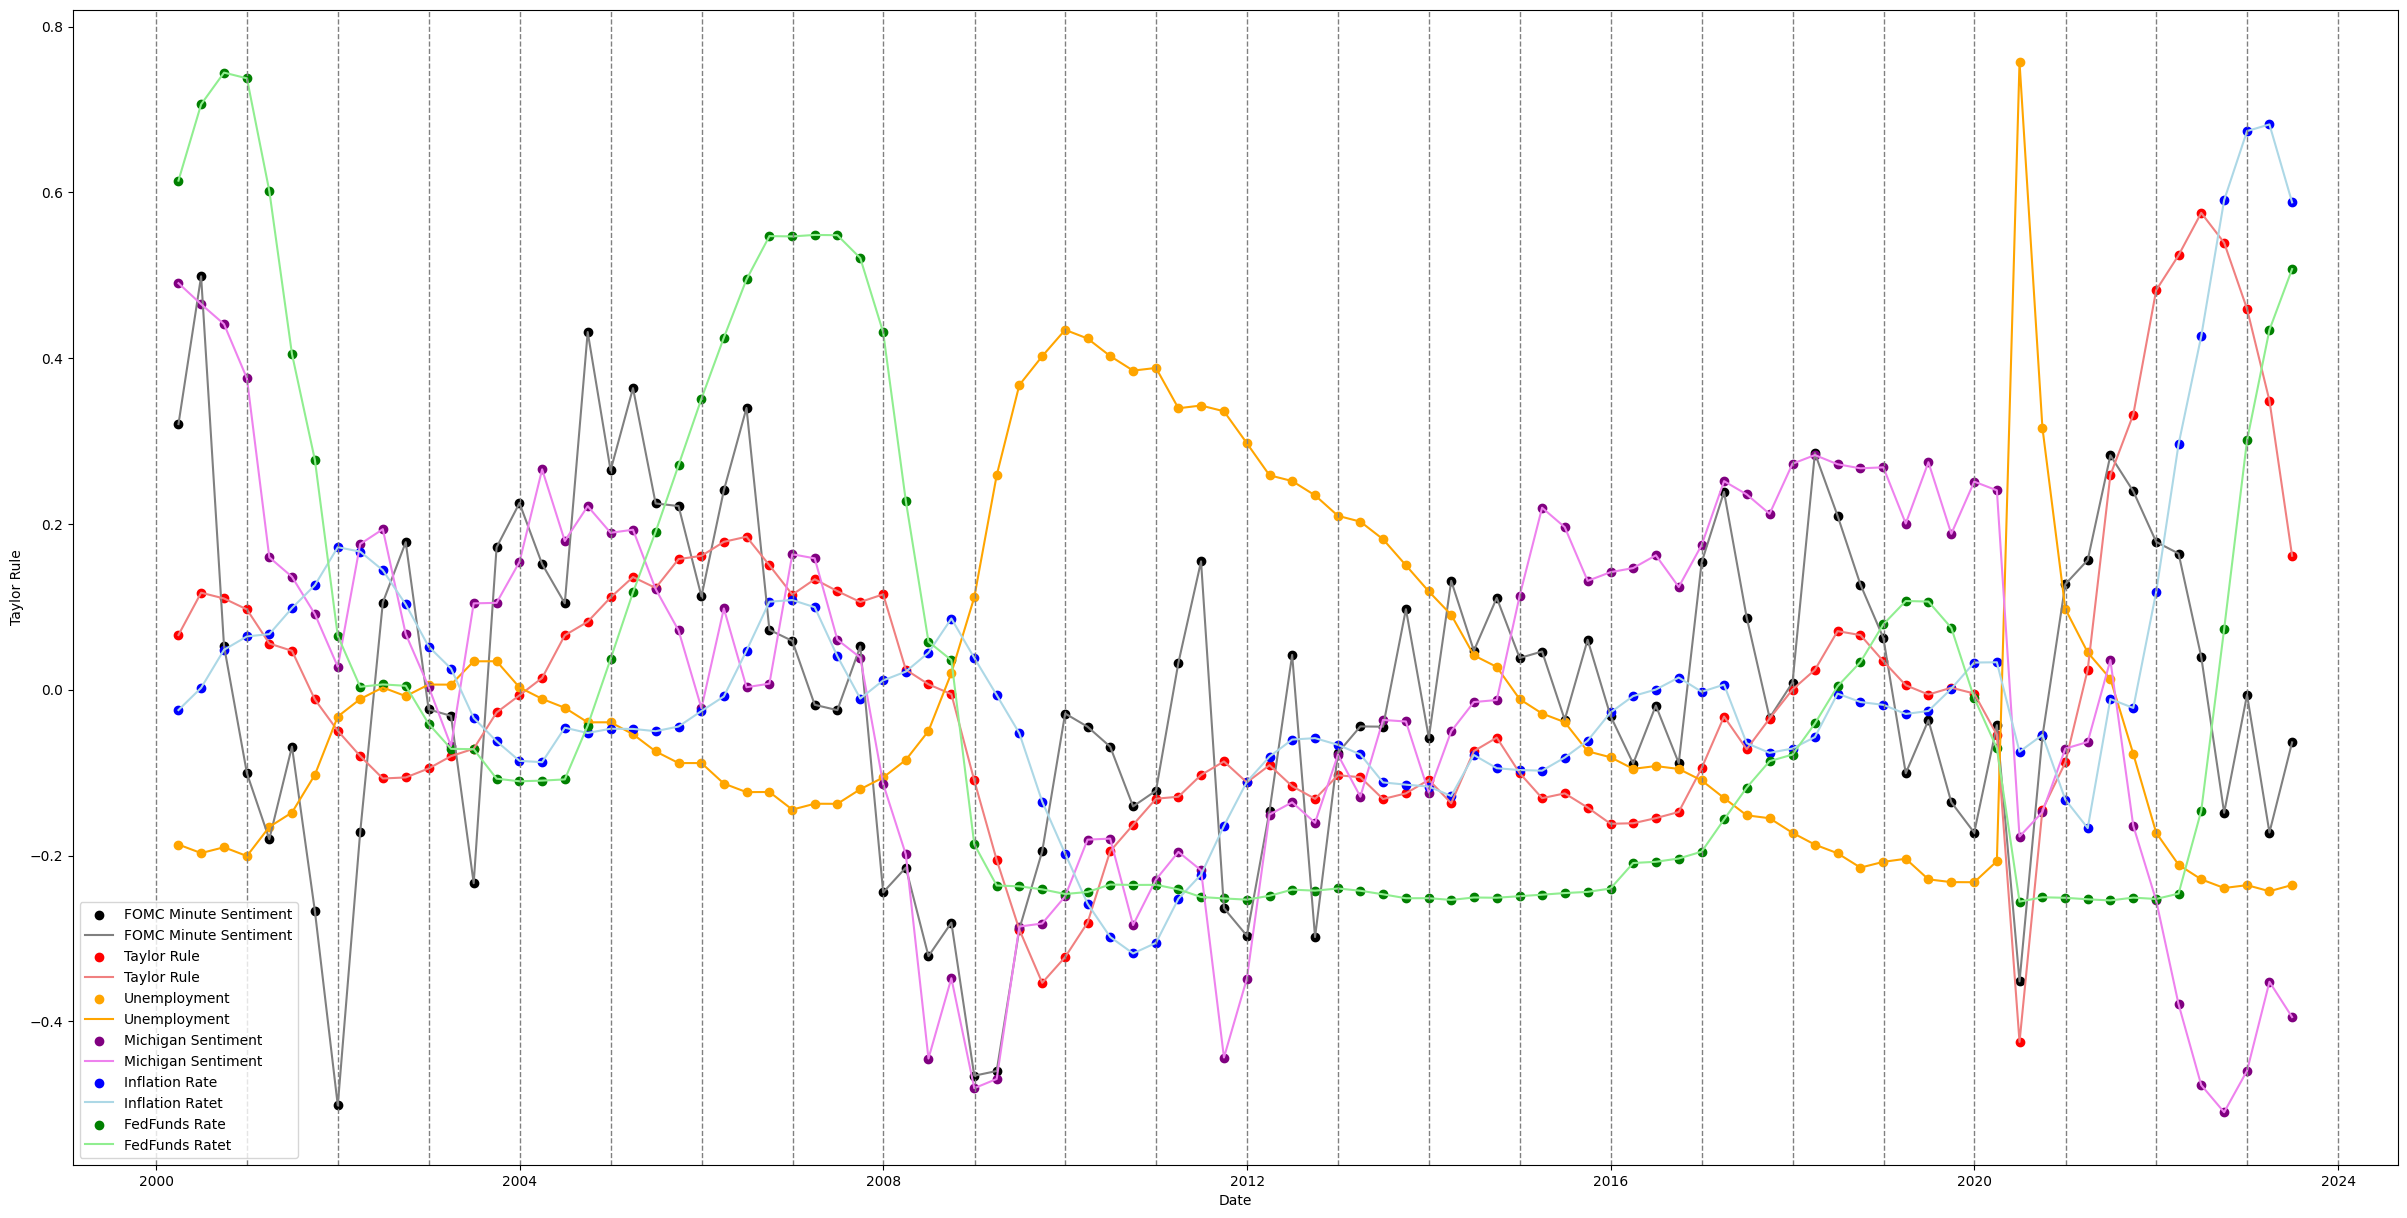

In [ ]:
print(sentiment.columns)

#Graph the Data
fig, ax = plt.subplots(figsize = (30, 15))


ax.scatter(sentiment['date'], sentiment['minute_sentiment'], label='FOMC Minute Sentiment', color='black')
ax.plot(sentiment['date'], sentiment['minute_sentiment'], label='FOMC Minute Sentiment', color='grey')

ax.scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='red')
ax.plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='lightcoral')

ax.scatter(sentiment['date'], sentiment['unemployment'], label='Unemployment', color='orange')
ax.plot(sentiment['date'], sentiment['unemployment'], label='Unemployment', color='orange')

ax.scatter(sentiment['date'], sentiment['michigan_sentiment'], label='Michigan Sentiment', color='purple')
ax.plot(sentiment['date'], sentiment['michigan_sentiment'], label='Michigan Sentiment', color='violet')

ax.scatter(sentiment['date'], sentiment['inflation'], label='Inflation Rate', color='blue')
ax.plot(sentiment['date'], sentiment['inflation'], label='Inflation Ratet', color='lightblue')

ax.scatter(sentiment['date'], sentiment['fedfunds'], label='FedFunds Rate', color='green')
ax.plot(sentiment['date'], sentiment['fedfunds'], label='FedFunds Ratet', color='lightgreen')


#Create a vertical line at every year 
for year in range(2000, 2025):
    ax.axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)

ax.set_xlabel('Date')
ax.set_ylabel('Taylor Rule')
ax.legend()
plt.show()


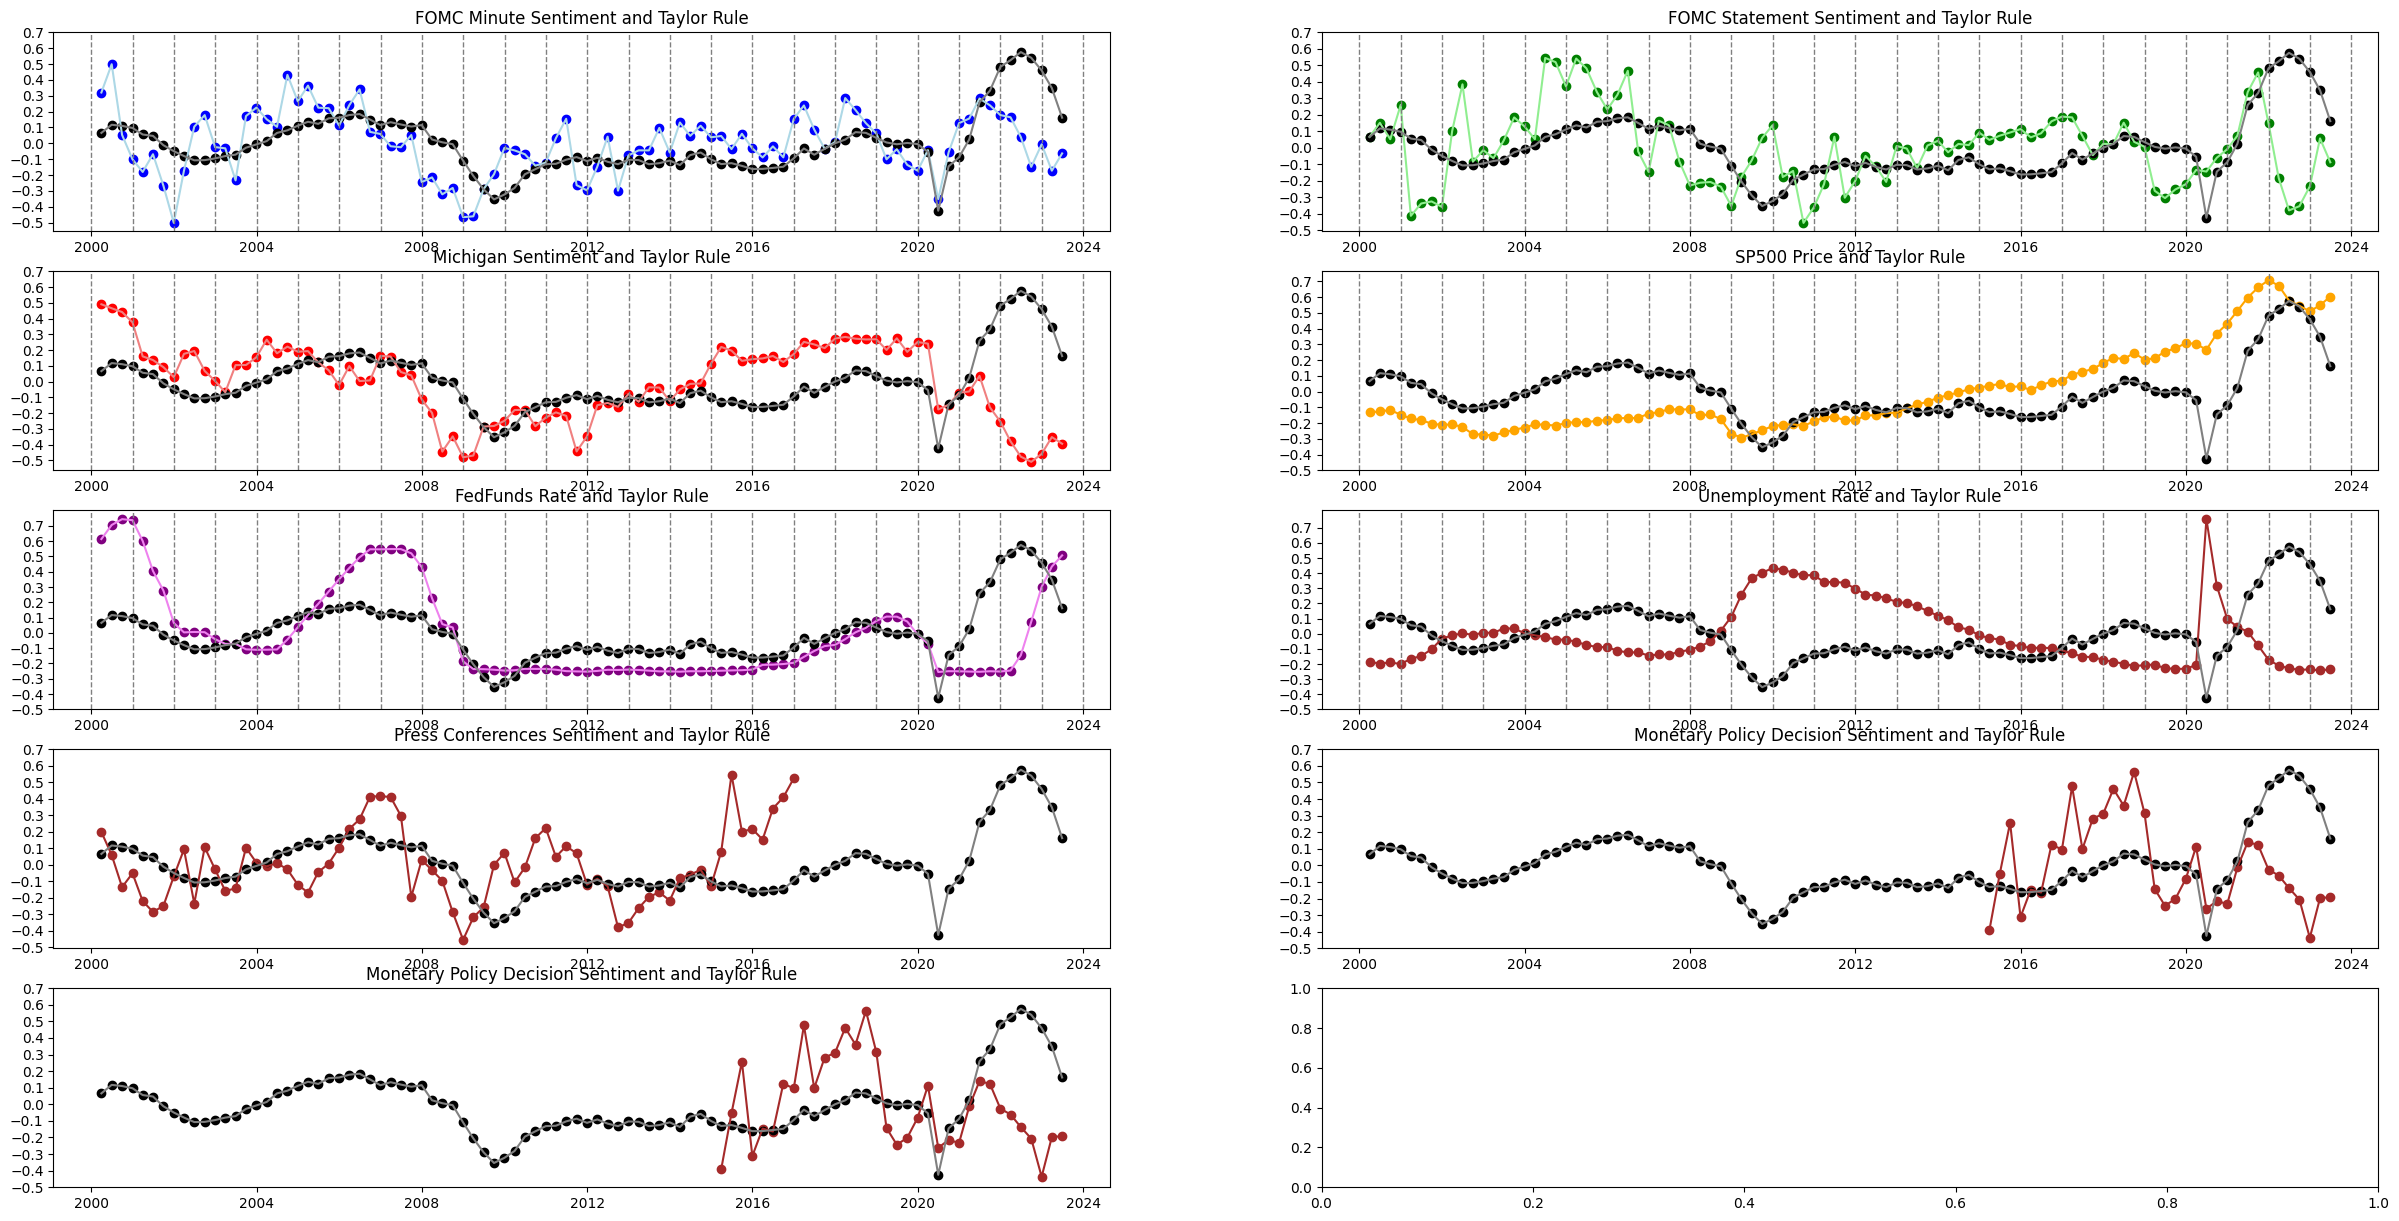

In [ ]:
#recreate the previous graph but using multiple subplots where every subplot is a different variable compared to the Taylor Rule
fig, ax = plt.subplots(5, 2, figsize = (50, 20))

ax[0, 0].scatter(sentiment['date'], sentiment['minute_sentiment'], label='FOMC Minute Sentiment', color='blue')
ax[0, 0].plot(sentiment['date'], sentiment['minute_sentiment'], label='FOMC Minute Sentiment', color='lightblue')
ax[0, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[0, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[0, 0].set_title('FOMC Minute Sentiment and Taylor Rule')
ax[0, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))


ax[0, 1].scatter(sentiment['date'], sentiment['statement_sentiment'], label='Statement Sentiment', color='green')
ax[0, 1].plot(sentiment['date'], sentiment['statement_sentiment'], label='Statement Sentiment', color='lightgreen')
ax[0, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[0, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[0, 1].set_title('FOMC Statement Sentiment and Taylor Rule')
ax[0, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[1, 0].scatter(sentiment['date'], sentiment['michigan_sentiment'], label='Michigan Sentiment', color='red')
ax[1, 0].plot(sentiment['date'], sentiment['michigan_sentiment'], label='Michigan Sentiment', color='lightcoral')
ax[1, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[1, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[1, 0].set_title('Michigan Sentiment and Taylor Rule')
ax[1, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[1, 1].scatter(sentiment['date'], sentiment['sp500_price'], label='SP500 Price', color='orange')
ax[1, 1].plot(sentiment['date'], sentiment['sp500_price'], label='SP500 Price', color='orange')
ax[1, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[1, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[1, 1].set_title('SP500 Price and Taylor Rule')
ax[1, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[2, 0].scatter(sentiment['date'], sentiment['fedfunds'], label='FedFunds Rate', color='purple')
ax[2, 0].plot(sentiment['date'], sentiment['fedfunds'], label='FedFunds Rate', color='violet')
ax[2, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[2, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[2, 0].set_title('FedFunds Rate and Taylor Rule')
ax[2, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[2, 1].scatter(sentiment['date'], sentiment['unemployment'], label='Unemployment Rate', color='brown')
ax[2, 1].plot(sentiment['date'], sentiment['unemployment'], label='Unemployment Rate', color='brown')
ax[2, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[2, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[2, 1].set_title('Unemployment Rate and Taylor Rule')
ax[2, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[3, 0].scatter(sentiment['date'], sentiment['pc_sentiment'], label='Press Conferences Sentiment', color='brown')
ax[3, 0].plot(sentiment['date'], sentiment['pc_sentiment'], label='Press Conferences Sentiment', color='brown')
ax[3, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[3, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[3, 0].set_title('Press Conferences Sentiment and Taylor Rule')
ax[3, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[3, 1].scatter(sentiment['date'], sentiment['mpd_sentiment'], label='Monetary Policy Decision Sentiment', color='brown')
ax[3, 1].plot(sentiment['date'], sentiment['mpd_sentiment'], label='Monetary Policy Decision Sentiment', color='brown')
ax[3, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[3, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[3, 1].set_title('Monetary Policy Decision Sentiment and Taylor Rule')
ax[3, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[4, 0].scatter(sentiment['date'], sentiment['fed_speech_sentiment'], label='Fed Speech Sentiment', color='brown')
ax[4, 0].plot(sentiment['date'], sentiment['fed_speech_sentiment'], label='Fed Speech Sentiment', color='brown')
ax[4, 0].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[4, 0].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[4, 0].set_title('Fed Speech Sentiment and Taylor Rule')
ax[4, 0].set_yticks(np.arange(-0.5, 0.8, 0.1))

ax[4, 1].scatter(sentiment['date'], sentiment['ecb_speech_sentiment'], label='ECB Speech Sentiment', color='brown')
ax[4, 1].plot(sentiment['date'], sentiment['ecb_speech_sentiment'], label='ECB Speech Sentiment', color='brown')
ax[4, 1].scatter(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='black')
ax[4, 1].plot(sentiment['date'], sentiment['taylor'], label='Taylor Rule', color='grey')
ax[4, 1].set_title('ECB Speech Sentiment and Taylor Rule')
ax[4, 1].set_yticks(np.arange(-0.5, 0.8, 0.1))



#Create a vertical line at every year
for i in range(3):
    for j in range(2):
        for year in range(2000, 2025):
            ax[i, j].axvline(pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', lw=1)
            
plt.show()

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Assuming 'sentiment' is your DataFrame and it has been properly preprocessed

# Create subplots
fig = make_subplots(rows=1, cols=1)

# Add traces
fig.add_trace(go.Scatter(x=sentiment['date'], y=sentiment['statement_sentiment'], mode='lines', name='FOMC Statement Sentiment'))
fig.add_trace(go.Scatter(x=sentiment['date'], y=sentiment['minute_sentiment'], mode='lines', name='FOMC Minute Sentiment'))
fig.add_trace(go.Scatter(x=sentiment['date'], y=sentiment['taylor'], mode='lines', name='Taylor Rule'))
fig.add_trace(go.Scatter(x=sentiment['date'], y=sentiment['fedfunds'], mode='lines', name='fedfunds'))
fig.add_trace(go.Scatter(x=sentiment['date'], y=sentiment['sp500_price'], mode='lines', name='SP500 Price'))
fig.add_trace(go.Scatter(x=sentiment['date'], y=sentiment['vix_sentiment'], mode='lines', name='VIX Sentiment'))

# Update layout for interactive functionality
fig.update_layout(
    title='Interactive Plot',
    xaxis_title='Date',
    yaxis_title='Value',
    showlegend=True
)

# Add vertical lines at each year start for reference (this is just an example, adjust as necessary)
for year in range(sentiment['date'].dt.year.min(), sentiment['date'].dt.year.max() + 1):
    fig.add_vline(x=f'{year}-01-01', line=dict(color='gray', dash='dash'))

# Show the interactive plot
fig.show()
#Export the plot as html
fig.write_html("/Users/kylenabors/Documents/Database/Models/FinBERT Models/interactive_plot.html")
